<a href="https://colab.research.google.com/github/JungWoo-Chae/GANs-in-action/blob/master/2_AE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



> # **GANs In Action**
## **Chapter 2: Autoencoder**
This is Pytorch implementation of the code from *GANs in Action Deep Learning with Generative Adversarial Networks (GANs)*  by Manning Books.

This code was implemented from the [following code](https://github.com/GANs-in-Action/gans-in-action/blob/master/chapter-2/Chapter_2_Autoencoder.ipynb), which is written by [Jakub Langr](https://github.com/jakubLangr) and [Vladimir Bok](https://github.com/vbok).

Like the code mentioned before , This was implemented at Google Colabotory.

The goal I aimmed for was studying Pytorch in comparison with Tensorflow.keras

For Rerunning the code, This code was built in torch 1.6.0



## Imports





In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.stats import norm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from torchsummary import summary

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Hyperparameters.



In [ ]:
batch_size = 100
original_dim = 784
latent_dim = 2
intermediate_dim = 256
epochs = 10
epsilon_std = 1.0

# Define Variational Autoencoder

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self, original_dim
        , latent_dim
        , intermediate_dim
        , epsilon_std
        ):
        super(AutoEncoder, self).__init__()

        self.epsilon_std = epsilon_std
        
        self.encode_fc1 = nn.Linear(original_dim, intermediate_dim)
        self.encode_fc2 = nn.Linear(intermediate_dim, latent_dim)
        self.encode_fc3 = nn.Linear(intermediate_dim, latent_dim)

        self.decode_fc1 = nn.Linear(latent_dim, intermediate_dim)
        self.decode_fc2 = nn.Linear(intermediate_dim, original_dim)

    def sampling(self, mean, log_var):
        std = torch.exp(log_var / 2)
        epsilon = torch.randn_like(log_var)
        return mean +  std * epsilon * self.epsilon_std

    def encode(self, x):
        h = F.relu(self.encode_fc1(x))
        z_mean = self.encode_fc2(h)
        z_log_var =  self.encode_fc3(h)
        return z_mean, z_log_var, self.sampling(z_mean, z_log_var)

    def decode(self, z):
        decoder_h = F.relu(self.decode_fc1(z))
        x_decoded = F.sigmoid(self.decode_fc2(decoder_h))
        return x_decoded

    def forward(self, x):        
        z_mean, z_log_var, z = self.encode(x)
        output = self.decode(z)
        return output, z_mean, z_log_var

In [ ]:
vae = AutoEncoder(
    original_dim = original_dim
    , latent_dim = latent_dim
    , intermediate_dim = intermediate_dim
    , epsilon_std = epsilon_std
)
vae=vae.to(device)

In [ ]:
summary(vae, (1, original_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 256]         200,960
            Linear-2                 [-1, 1, 2]             514
            Linear-3                 [-1, 1, 2]             514
            Linear-4               [-1, 1, 256]             768
            Linear-5               [-1, 1, 784]         201,488
Total params: 404,244
Trainable params: 404,244
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 1.54
Estimated Total Size (MB): 1.55
----------------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [ ]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Lambda(lambda x: x.view(-1))
    ])

In [ ]:
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                           shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=testset.__len__(),
                                         shuffle=False, num_workers=2)

## Define the losses and run the model!

In [ ]:
def vae_kl_loss(mean, log_var):
    loss = -0.5*torch.sum(1+log_var - torch.square(mean) - torch.exp(log_var))
    return loss

optimizer = torch.optim.RMSprop(vae.parameters(),lr=0.01)

criterion = nn.BCELoss(size_average=False)

vae.train()
total_step = len(train_loader)
for epoch in range(epochs):
    print(epoch)
    for i, (images, _) in enumerate(train_loader):
        
        images = images.to(device)        
        outputs, z_mean, z_log_var = vae(images)
        kl_loss = vae_kl_loss(z_mean, z_log_var)     
        bce_loss = criterion(outputs, images)

        loss = kl_loss/784 + bce_loss 

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        

        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                  .format(epoch+1, epochs, i+1, total_step, loss.item() ))

0


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch [1/20], Step [100/600], Loss: 17741.0039, Loss: 975.0965, Loss: 17739.7598
Epoch [1/20], Step [200/600], Loss: 16576.1777, Loss: 1375.8104, Loss: 16574.4238
Epoch [1/20], Step [300/600], Loss: 17175.7461, Loss: 1633.6536, Loss: 17173.6621
Epoch [1/20], Step [400/600], Loss: 17220.0801, Loss: 1595.3750, Loss: 17218.0449
Epoch [1/20], Step [500/600], Loss: 17434.4922, Loss: 2187.1008, Loss: 17431.7031
Epoch [1/20], Step [600/600], Loss: 15795.4355, Loss: 2102.2275, Loss: 15792.7539
1
Epoch [2/20], Step [100/600], Loss: 16285.1689, Loss: 1822.8940, Loss: 16282.8438
Epoch [2/20], Step [200/600], Loss: 16570.0078, Loss: 2211.3564, Loss: 16567.1875
Epoch [2/20], Step [300/600], Loss: 15695.9150, Loss: 2476.2632, Loss: 15692.7568
Epoch [2/20], Step [400/600], Loss: 15435.4580, Loss: 3421.2158, Loss: 15431.0938
Epoch [2/20], Step [500/600], Loss: 16200.5674, Loss: 2241.0859, Loss: 16197.7090
Epoch [2/20], Step [600/600], Loss: 15441.0371, Loss: 2809.2539, Loss: 15437.4541
2
Epoch [3/20],

 ## Figure in 2.6.

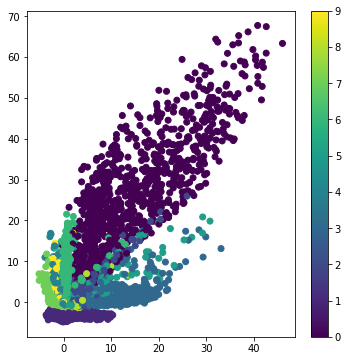

In [ ]:
vae.eval()
dataiter = iter(test_loader)
x_test, y_test = dataiter.next()
x_test_encoded = vae.encode(x_test.cuda())[2]
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:,0].cpu().detach().numpy(), x_test_encoded[:,1].cpu().detach().numpy(), c=y_test, cmap='viridis')
plt.colorbar()
plt.show()

## Figure 2.7.


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


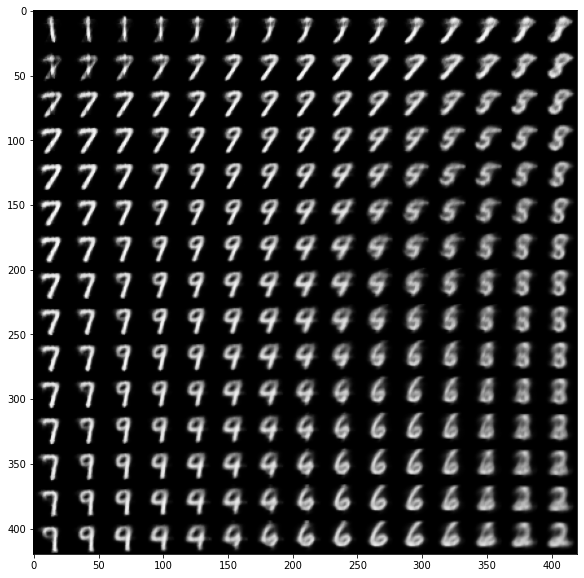

In [ ]:
n = 15 
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = vae.decode(torch.from_numpy(z_sample).float().to(device))
        digit = x_decoded[0].view(digit_size, digit_size).cpu().detach().numpy()
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()